In [72]:
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns

import datetime as datetime
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import datetime
from datetime import date


In [73]:
df = pd.read_csv('covid_19_indonesia_time_series_all.csv')
df.head(5)

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,...,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Total Deaths per 100rb,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
0,3/1/2020,ID-JK,DKI Jakarta,2,0,0,2,39,20,41,...,-6.204699,0.18,3.60,0.0,1.84,0.18,51.28%,105.13%,NaN,NaN
1,3/2/2020,ID-JK,DKI Jakarta,2,0,0,2,41,20,41,...,-6.204699,0.18,3.78,0.0,1.84,0.18,48.78%,100.00%,1.0,1.0
2,3/2/2020,IDN,Indonesia,2,0,0,2,2,0,0,...,-0.789275,0.01,0.01,0.0,0.00,0.00,0.00%,0.00%,NaN,NaN
3,3/2/2020,ID-RI,Riau,1,0,0,1,2,0,3,...,0.511648,0.16,0.33,0.0,0.00,0.00,0.00%,150.00%,NaN,NaN
4,3/3/2020,ID-JK,DKI Jakarta,2,0,0,2,43,20,41,...,-6.204699,0.18,3.96,0.0,1.84,0.18,46.51%,95.35%,1.0,1.0


In [74]:
print('The shape of our features is:', df.shape)

The shape of our features is: (21759, 38)


In [75]:
df.describe()

,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,City or Regency,Total Regencies,...,Population Density,Longitude,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Total Deaths per 100rb,Growth Factor of New Cases,Growth Factor of New Deaths
count,21759.000000,21759.000000,21759.000000,21759.000000,2.175900e+04,21759.000000,2.175900e+04,21759.000000,0.0,21759.000000,...,21759.000000,21759.000000,21759.000000,21759.000000,21759.000000,21759.000000,21759.000000,21759.000000,20572.000000,19292.000000
mean,391.293580,13.220415,377.310998,0.762167,8.525997e+04,2648.289352,7.671260e+04,5899.079002,NaN,24.160256,...,744.989784,113.680803,-2.731868,29.393033,6183.650588,0.852727,163.542156,16.354192,1.395671,1.074145
std,2074.551043,76.482617,1999.062563,937.213509,3.685133e+05,11776.011067,3.403957e+05,27518.102431,NaN,68.708265,...,2743.209719,9.857587,3.608264,69.941090,10288.123342,2.277310,254.195761,25.419595,3.080207,1.578502
min,0.000000,0.000000,0.000000,-25725.000000,1.000000e+00,0.000000,0.000000e+00,-2306.000000,NaN,1.000000,...,8.590000,96.910522,-8.682205,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,4.000000,-16.000000,1.822500e+03,50.000000,1.038500e+03,182.000000,NaN,7.000000,...,47.790000,106.109004,-6.204699,1.750000,415.915000,0.000000,10.880000,1.090000,0.650000,0.660000
50%,41.000000,1.000000,31.000000,0.000000,1.078000e+04,283.000000,8.745000e+03,919.000000,NaN,11.000000,...,103.840000,113.417654,-2.461746,8.160000,2727.460000,0.180000,73.550000,7.350000,0.990000,1.000000
75%,151.000000,5.000000,143.000000,27.000000,3.646450e+04,1050.000000,3.293250e+04,2607.500000,NaN,18.000000,...,262.700000,121.201093,0.212037,26.260000,7374.120000,0.750000,195.850000,19.585000,1.330000,1.000000
max,56757.000000,2069.000000,48832.000000,36726.000000,4.257243e+06,143858.000000,4.105680e+06,574135.000000,NaN,416.000000,...,16334.310000,138.696030,4.225615,1348.130000,79663.790000,63.800000,1533.980000,153.400000,175.000000,134.500000


In [76]:
df.columns

Index(['Date', 'Location ISO Code', 'Location', 'New Cases', 'New Deaths',
       'New Recovered', 'New Active Cases', 'Total Cases', 'Total Deaths',
       'Total Recovered', 'Total Active Cases', 'Location Level',
       'City or Regency', 'Province', 'Country', 'Continent', 'Island',
       'Time Zone', 'Special Status', 'Total Regencies', 'Total Cities',
       'Total Districts', 'Total Urban Villages', 'Total Rural Villages',
       'Area (km2)', 'Population', 'Population Density', 'Longitude',
       'Latitude', 'New Cases per Million', 'Total Cases per Million',
       'New Deaths per Million', 'Total Deaths per Million',
       'Total Deaths per 100rb', 'Case Fatality Rate', 'Case Recovered Rate',
       'Growth Factor of New Cases', 'Growth Factor of New Deaths'],
      dtype='object')

In [77]:
date2=[]
for item in df['Date']:
    item2=item.split('/')
    month=int(item2[0])
    day=int(item2[1])
    year=int(item2[2])
    date2+=[datetime.date(year,month,day)]
df['Date']=date2
df['Date'] = pd.to_datetime(df['Date'])

In [78]:
df.head()

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,...,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Total Deaths per 100rb,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
0,2020-03-01,ID-JK,DKI Jakarta,2,0,0,2,39,20,41,...,-6.204699,0.18,3.60,0.0,1.84,0.18,51.28%,105.13%,NaN,NaN
1,2020-03-02,ID-JK,DKI Jakarta,2,0,0,2,41,20,41,...,-6.204699,0.18,3.78,0.0,1.84,0.18,48.78%,100.00%,1.0,1.0
2,2020-03-02,IDN,Indonesia,2,0,0,2,2,0,0,...,-0.789275,0.01,0.01,0.0,0.00,0.00,0.00%,0.00%,NaN,NaN
3,2020-03-02,ID-RI,Riau,1,0,0,1,2,0,3,...,0.511648,0.16,0.33,0.0,0.00,0.00,0.00%,150.00%,NaN,NaN
4,2020-03-03,ID-JK,DKI Jakarta,2,0,0,2,43,20,41,...,-6.204699,0.18,3.96,0.0,1.84,0.18,46.51%,95.35%,1.0,1.0


In [79]:
data = df.drop(['City or Regency','Location ISO Code','Province','Country','Continent','Island','Time Zone','Special Status',
                'Total Regencies','Total Cities','Total Districts','Total Urban Villages',
                'Total Rural Villages','New Cases per Million','Total Cases per Million',
                'New Deaths per Million','Total Deaths per Million','Case Fatality Rate',
                'Case Recovered Rate','Growth Factor of New Cases','Growth Factor of New Deaths'],axis = 1)
data = data.fillna(0)
data.head(5)

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Area (km2),Population,Population Density,Longitude,Latitude,Total Deaths per 100rb
0,2020-03-01,DKI Jakarta,2,0,0,2,39,20,41,-22,Province,664,10846145,16334.31,106.836118,-6.204699,0.18
1,2020-03-02,DKI Jakarta,2,0,0,2,41,20,41,-20,Province,664,10846145,16334.31,106.836118,-6.204699,0.18
2,2020-03-02,Indonesia,2,0,0,2,2,0,0,2,Country,1916907,265185520,138.34,113.921327,-0.789275,0.00
3,2020-03-02,Riau,1,0,0,1,2,0,3,-1,Province,87024,6074100,69.80,101.805109,0.511648,0.00
4,2020-03-03,DKI Jakarta,2,0,0,2,43,20,41,-18,Province,664,10846145,16334.31,106.836118,-6.204699,0.18


In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21759 entries, 0 to 21758
Data columns (total 17 columns):
Date                      21759 non-null datetime64[ns]
Location                  21759 non-null object
New Cases                 21759 non-null int64
New Deaths                21759 non-null int64
New Recovered             21759 non-null int64
New Active Cases          21759 non-null int64
Total Cases               21759 non-null int64
Total Deaths              21759 non-null int64
Total Recovered           21759 non-null int64
Total Active Cases        21759 non-null int64
Location Level            21759 non-null object
Area (km2)                21759 non-null int64
Population                21759 non-null int64
Population Density        21759 non-null float64
Longitude                 21759 non-null float64
Latitude                  21759 non-null float64
Total Deaths per 100rb    21759 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(10), object(2)
memory usage:

In [81]:
newest = data.drop_duplicates(subset='Location', keep="last")
newest.head()

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Area (km2),Population,Population Density,Longitude,Latitude,Total Deaths per 100rb
21364,2021-11-21,Gorontalo,1,0,0,1,11834,460,11374,0,Province,11257,1180651,104.88,122.376058,0.687003,38.96
21617,2021-11-28,Maluku Utara,2,0,3,-1,12101,303,11757,41,Province,31983,1307803,40.89,127.539107,0.212037,23.17
21700,2021-12-01,Bengkulu,1,0,0,1,23104,473,22612,19,Province,19919,1999539,100.38,102.338421,-3.533584,23.66
21712,2021-12-01,Kalimantan Utara,1,0,0,1,35885,811,35039,35,Province,75468,648407,8.59,116.218879,2.891013,125.08
21714,2021-12-01,Kepulauan Riau,2,0,0,2,53884,1748,52120,16,Province,8202,1929400,235.24,108.261746,3.916346,90.60


In [82]:
newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], ascending=False)

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Area (km2),Population,Population Density,Longitude,Latitude,Total Deaths per 100rb
21733,2021-12-02,DKI Jakarta,28,0,0,28,864045,13596,849875,574,Province,664,10846145,16334.31,106.836118,-6.204699,125.35
21737,2021-12-02,Jawa Barat,83,0,6,77,707934,14737,692101,1096,Province,35378,45161325,1276.55,107.603708,-6.920432,32.63
21738,2021-12-02,Jawa Tengah,30,1,6,23,486435,30225,454837,1373,Province,32801,36364072,1108.64,110.201115,-7.259097,83.12
21739,2021-12-02,Jawa Timur,35,0,11,24,399478,29697,369537,244,Province,47803,40479023,846.78,112.732941,-7.723346,73.36
21743,2021-12-02,Kalimantan Timur,7,0,2,5,158245,5449,152714,82,Province,129067,3552191,27.52,116.468440,0.453858,153.40
21734,2021-12-02,Daerah Istimewa Yogyakarta,7,0,0,7,156769,5263,150965,541,Province,3133,3631015,1158.90,110.444878,-7.894502,144.95
21732,2021-12-02,Banten,16,0,1,15,132693,2688,129872,133,Province,9663,10722374,1109.64,106.109004,-6.456736,25.07
21750,2021-12-02,Riau,4,0,0,4,128825,4109,124123,593,Province,87024,6074100,69.80,101.805109,0.511648,67.65
21731,2021-12-02,Bali,15,1,1,13,114233,4046,110003,184,Province,5780,4216171,729.43,115.131714,-8.369472,95.96
21751,2021-12-02,Sulawesi Selatan,1,1,1,-1,109919,2238,107630,51,Province,46717,9426885,201.78,120.162056,-3.731081,23.74


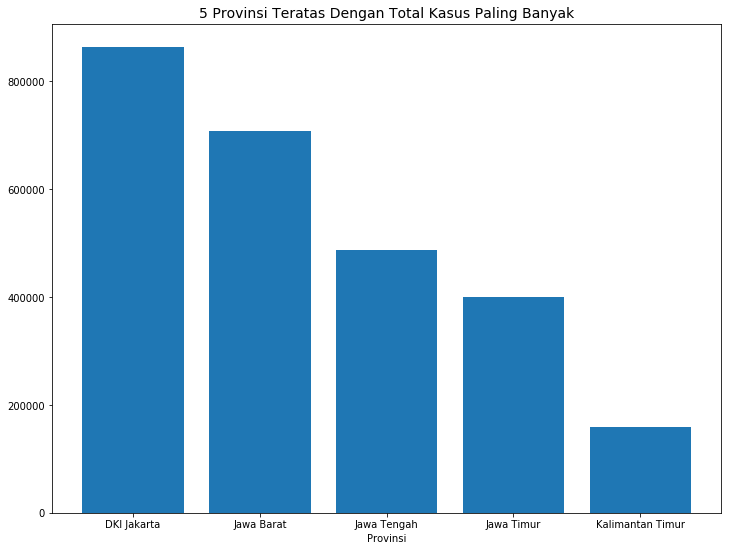

In [83]:
plt.figure(figsize=(12,9))
plt.bar(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], ascending=False)['Location'].values[:5], newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], ascending=False)['Total Cases'].values[:5])
plt.title('5 Provinsi Teratas Dengan Total Kasus Paling Banyak', fontsize=14)
plt.xlabel('Provinsi')
plt.show()

In [84]:
(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], ascending=False)['Total Cases'].values[:2][0] - newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], ascending=False)['Total Cases'].values[:2][1])/newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], ascending=False)['Total Cases'].values[:2][0] * 100

18.06746176414423

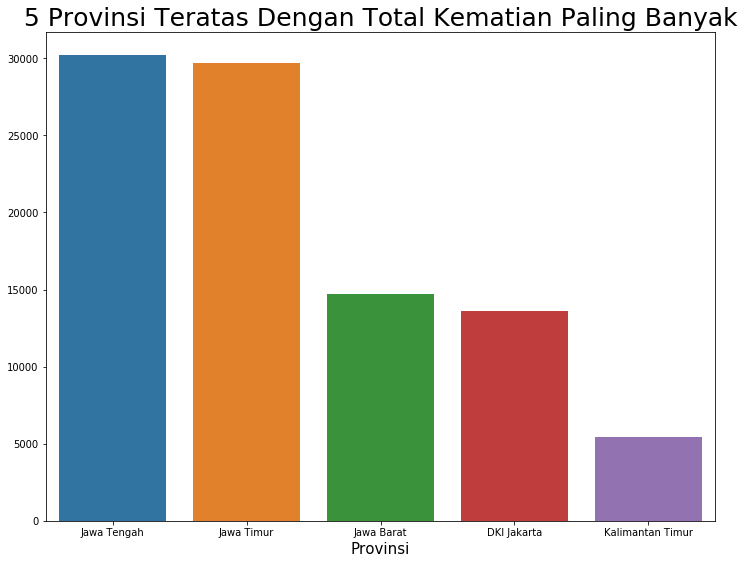

In [85]:
plt.figure(figsize=(12,9))

sns.barplot(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Deaths'], ascending=False)['Location'].values[:5],  newest[newest.Location != 'Indonesia'].sort_values(by=['Total Deaths'], ascending=False)['Total Deaths'].values[:5])
plt.title('5 Provinsi Teratas Dengan Total Kematian Paling Banyak', fontsize=25)
plt.xlabel('Provinsi', fontsize=15)
plt.show()

In [86]:
data = data[['New Cases','New Deaths','New Recovered','New Active Cases','Total Cases','Total Deaths','Total Recovered','Total Active Cases']]
data.tail()

,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases
21754,2,0,0,2,34715,1056,33566,93
21755,4,0,0,4,89849,2152,87605,92
21756,4,0,0,4,59937,3071,56830,36
21757,4,0,1,3,106045,2889,103061,95
21758,245,8,328,-91,4257243,143858,4105680,7705


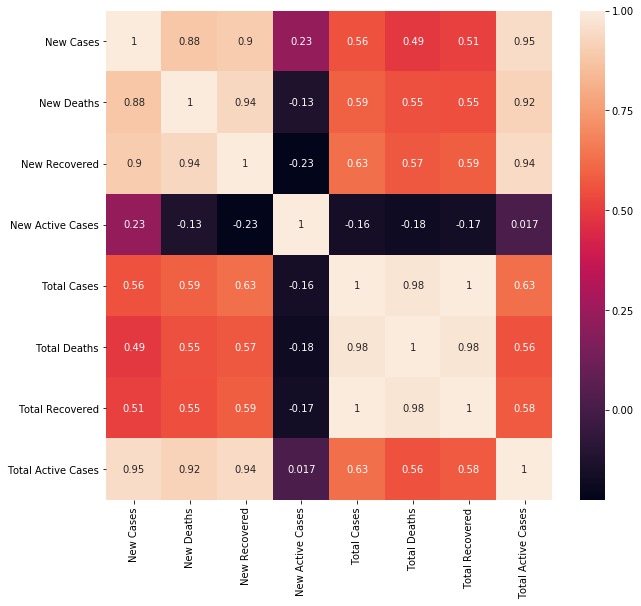

In [87]:
plt.figure(figsize=(10,9))
sns.heatmap(data.corr(), annot=True)
plt.show()

In [88]:
data = data[['New Cases','New Deaths','New Recovered','Total Cases','Total Deaths','Total Recovered','Total Active Cases']]
data.tail()

,New Cases,New Deaths,New Recovered,Total Cases,Total Deaths,Total Recovered,Total Active Cases
21754,2,0,0,34715,1056,33566,93
21755,4,0,0,89849,2152,87605,92
21756,4,0,0,59937,3071,56830,36
21757,4,0,1,106045,2889,103061,95
21758,245,8,328,4257243,143858,4105680,7705


## SPLIT DATA

In [89]:
X = data[['New Cases','New Recovered','Total Cases','Total Deaths','Total Recovered','Total Active Cases']]
y = data[['New Deaths']]

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.25)

In [91]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

## Regresi Linier

In [92]:
from sklearn.linear_model import LinearRegression

lnr = LinearRegression(normalize=True)
lnr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

## Model Evaulate

In [93]:
print(lnr.intercept_)

[13.1928427]


In [94]:
coeff_df = pd.DataFrame(lnr.coef_[0],X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
New Cases,9.098530
New Recovered,48.182874
Total Cases,-19.884195
Total Deaths,42.976010
Total Recovered,-24.548376
Total Active Cases,18.692181


In [151]:
pred = lnr.predict(X_test)

Text(0, 0.5, 'pred')

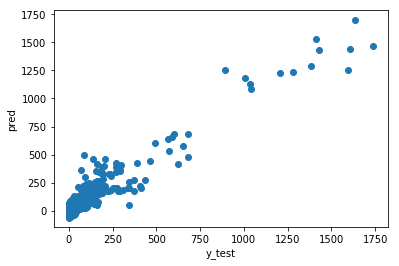

In [153]:
plt.scatter(y_test, pred)
plt.xlabel('y_test')
plt.ylabel('pred')

In [143]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square:', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [144]:
test_pred = lnr.predict(X_test)
train_pred = lnr.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 6.699471921405479
MSE: 491.36562286586167
RMSE: 22.1667684353372
R2 Square: 0.9171809552893162
__________________________________
Train set evaluation:
_____________________________________
MAE: 7.0365039447463
MSE: 577.6367225585276
RMSE: 24.034074198074027
R2 Square: 0.900773973515043
__________________________________


In [142]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,6.699472,491.365623,22.166768,0.917181,-1.361979


## SVM

In [100]:
from sklearn.svm import SVR

svr = SVR(C=10, kernel='linear')
svr.fit(X_train, y_train)

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [101]:
print(svr.intercept_)

[11.67224613]


In [102]:
coeff_df = pd.DataFrame(svr.coef_[0],X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
New Cases,21.008190
New Recovered,37.149935
Total Cases,-5.215410
Total Deaths,11.650857
Total Recovered,-6.312695
Total Active Cases,3.197602


In [103]:
svr_pred = svr.predict(X_test)

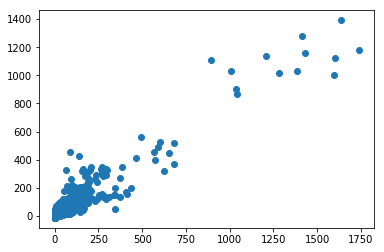

In [104]:
plt.scatter(y_test, svr_pred)

In [145]:
svr_test_pred = svr.predict(X_test)
svr_train_pred = svr.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, svr_test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, svr_train_pred)

Test set evaluation:
_____________________________________
MAE: 5.604404152057835
MSE: 603.1073967241927
RMSE: 24.558244984611434
R2 Square: 0.8983470228069239
__________________________________
Train set evaluation:
_____________________________________
MAE: 6.0249701014895685
MSE: 808.7733516265168
RMSE: 28.438940761331406
R2 Square: 0.8610694873183224
__________________________________


In [106]:
results_df_2 = pd.DataFrame(data=[["SVR", *evaluate(y_test, svr_test_pred) , cross_val(SVR())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,6.699472,491.365623,22.166768,0.917181,-1.361979
1,SVR,5.604404,603.107397,24.558245,0.898347,-1.781377


In [114]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_train, y_train)

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [115]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 3.58053233902995
MSE: 246.31072680755452
RMSE: 15.694289624177149
R2 Square 0.958484643314649
__________________________________
Train set evaluation:
_____________________________________
MAE: 1.3422150594181335
MSE: 28.08424564731371
RMSE: 5.299457108734225
R2 Square 0.995175708202783
__________________________________


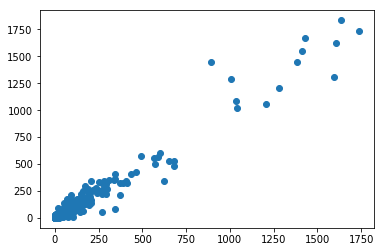

In [108]:
plt.scatter(y_test, test_pred)

In [109]:
results_df_2 = pd.DataFrame(data=[["RF Regression", *evaluate(y_test, test_pred) , cross_val(RandomForestRegressor())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector 

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,6.699472,491.365623,22.166768,0.917181,-1.361979
1,SVR,5.604404,603.107397,24.558245,0.898347,-1.781377
2,RF Regression,3.577197,242.844024,15.583454,0.959069,0.370881


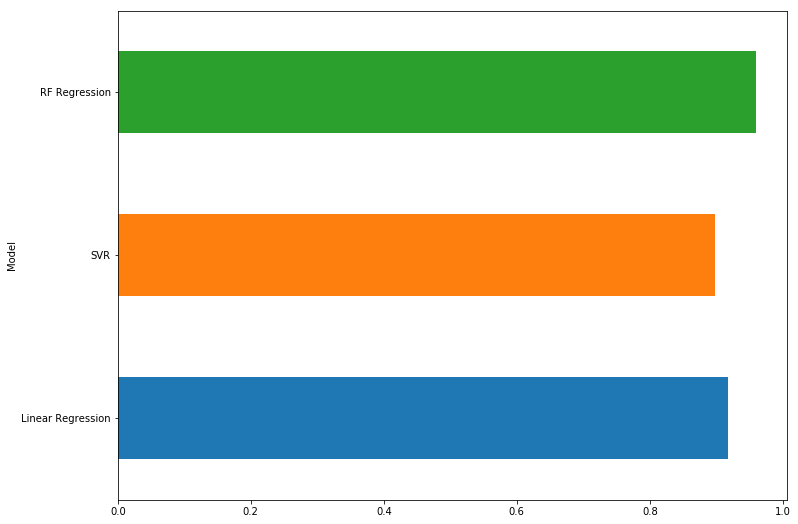

In [110]:
results_df.set_index('Model', inplace=True)
results_df['R2 Square'].plot(kind='barh', figsize=(12,9))